![title](images/header.png)

# Vb - Supervised Classification with CAFI data
-------
this notebook performs a supervised classification of probability of forest change for one country using the merged eSBAE and CEO data trained on the interpreted data from CAFI DDD phase I (2015-2020).  
The change probability is then divided into 3 strata using kmeans
The modeled data are exported to csv for the following script to extract samples for validation in CEO.

This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [215]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

### Parameters

In [216]:
ISO = 'GAB'

#### Import the CEO validated data from CAFI DDD first phase - output from script 5a
##### this file includes 13,115 points, randomly distributed over CAFI, with interpretation
##### additional attributes from CAFI rasters have been added (fragmentation, tree cover)
##### this file is available here: https://drive.google.com/file/d/1D1tkVVhKv6QNCQhLLfRo7eqz0VO3XZZF/view?usp=sharing
##### unzip and upload to your SEPAL workspace using Filezilla

In [217]:
trn_ceo = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_ceo_phaseI_att.csv', delimiter=',')
trn_ceo

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,...,sampling,ECO_CODE,ECO_NAME,ECO_NUM,ECODE_NAME,TropBiome,CAFI_LC_2015,Frag_2015,Treecov_2015,Biomass_2010
0,POINT (25.60212035 -11.69188784),1,181,97,2018.589,-738.678406,-1.354781,2016.597,0.111200,45954.212113,...,str_random,AT0704,Central Zambezian Miombo Woodlands,4.0,AT0704. Central Zambezian Miombo woodlands,2.0,2,5,52,94
1,POINT (19.01297774 6.404943059),2,153,90,2016.381,-1332.806396,-1.765601,2020.038,0.318602,53800.048638,...,str_random,AT0712,Northern Congolian Forest-Savanna Mosaic,12.0,AT0712. Northern Congolian forest-savanna mosaic,2.0,9,3,54,194
2,POINT (22.79183081 7.078410027),3,158,93,2016.915,-2419.585449,-2.557598,2020.003,0.116307,48050.450691,...,str_random,AT0705,East Sudanian Savanna,5.0,AT0705. East Sudanian savanna,2.0,11,2,33,9
3,POINT (27.43010212 -6.534839454),4,129,60,-1.000,0.000000,0.000000,2017.430,0.290449,37411.044881,...,str_random,AT0704,Central Zambezian Miombo Woodlands,4.0,AT0704. Central Zambezian Miombo woodlands,2.0,11,2,28,52
4,POINT (22.21214796 -9.940981517),5,140,79,2018.342,13.038783,-0.582325,2018.518,0.164515,32283.895600,...,str_random,AT0704,Central Zambezian Miombo Woodlands,4.0,AT0704. Central Zambezian Miombo woodlands,2.0,2,3,51,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13110,POINT (18.90329319 4.178378347),13112,123,80,-1.000,0.000000,0.000000,2016.468,0.395151,18018.418333,...,str_random,AT0124,Northeastern Congolian Lowland Forests,24.0,AT0124. Northeastern Congolian lowland forests,1.0,1,2,41,38
13111,POINT (17.17745164 -5.075794729),13113,113,63,2017.433,-750.342834,-1.426068,2018.485,0.284138,7684.125926,...,str_random,AT0718,Southern Congolian Forest-Savanna Mosaic,18.0,AT0718. Southern Congolian forest-savanna mosaic,2.0,1,2,59,39
13112,POINT (21.96690965 3.213589406),13114,116,67,2017.219,-84.756882,-0.863496,2018.118,0.284414,5417.638273,...,str_random,AT0124,Northeastern Congolian Lowland Forests,24.0,AT0124. Northeastern Congolian lowland forests,1.0,1,2,70,392
13113,POINT (27.81844527 -3.425142538),13115,134,71,2016.816,362.227112,0.848210,2020.036,0.562147,9395.833300,...,str_random,AT0124,Northeastern Congolian Lowland Forests,24.0,AT0124. Northeastern Congolian lowland forests,1.0,1,2,75,180


In [218]:
print(trn_ceo.columns.values)

['geometry' 'UniqueID' 'images' 'mon_images' 'bfast_change_date'
 'bfast_magnitude' 'bfast_means' 'cusum_change_date' 'cusum_confidence'
 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean'
 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min'
 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean'
 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean' 'brightness_sd'
 'brightness_min' 'brightness_max' 'greenness_mean' 'greenness_sd'
 'greenness_min' 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min'
 'wetness_max' 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ewma_jrc_date' 'ewma_jrc_change' 'ewma_jrc_magnitude' 'mosum_jrc_date'
 'mosum_jrc_change' 'mosum_jrc_magnitude' 'cusum_jrc_date'
 'cusum_jrc_change' 'cusum_jrc_magnitude' 'ccdc_change_date'
 'ccdc_magnitude' 'aspect' 'dw_class_mode' 'dw_tree_prob__max'
 'dw_tree_prob__min' 'dw_tree_prob__stdDev' 'dw_tree_prob_mean'
 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17' 'es

In [219]:
trn_gdf = gpd.GeoDataFrame(trn_ceo, geometry=gpd.points_from_xy(trn_ceo.LON, trn_ceo.LAT))

### Augmented dataset for country of interest (2015-2022)
#### this is the output folder from eSBAE script 4

In [220]:
# glob all files in the data augmentation output folder
files = Path('/home/sepal-user/module_results/esbae/GAB/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/DRC/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/COG/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/EQG/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/CMR/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/CAR/04_Dataset_Augmentation/Landsat/').glob('*geojson')

#### name of output file
##### this file consists of the eSBAE data for your country with a modeled change probability using CAFI phase I data

In [221]:
all_points_out_file = '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_1520_model.csv'

In [222]:
parquet_out = '/home/sepal-user/module_results/esbae/GAB/GAB_esbae.parquet'

In [223]:
esbae_att_out = '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_1522_att.csv'

In [224]:
#eSBAE columns to include in data export
cols_to_export = ['geometry', 'UniqueID',
                  #'dates', 'ts',
                  'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub','CAFI_LC_2015','Frag_2015', 'Treecov_2015', 'Biomass_2010']

#### end of parameters

# 1 - CEO data preparation
### 1.1 - Import CEO interpreted data

In [225]:
len(trn_gdf.index)

13115

### 1.2 - Inspect CEO interpreted data

Our ultimate goal is to use the CEO data for getting the probability of forest change via a series of classifications and their probability output. . , i.e. Forest-Non-Forest and a Change-No-Change classifcation.
Therefore we need to extract and trnasform the relevant information into a column of 0s and 1s. 

First let's look at the columns the CEO file contains.

In [226]:
trn_gdf.columns.tolist()

['geometry',
 'UniqueID',
 'images',
 'mon_images',
 'bfast_change_date',
 'bfast_magnitude',
 'bfast_means',
 'cusum_change_date',
 'cusum_confidence',
 'cusum_magnitude',
 'red_mean',
 'red_sd',
 'red_min',
 'red_max',
 'nir_mean',
 'nir_sd',
 'nir_min',
 'nir_max',
 'swir1_mean',
 'swir1_sd',
 'swir1_min',
 'swir1_max',
 'swir2_mean',
 'swir2_sd',
 'swir2_min',
 'swir2_max',
 'ndfi_mean',
 'ndfi_sd',
 'ndfi_min',
 'ndfi_max',
 'brightness_mean',
 'brightness_sd',
 'brightness_min',
 'brightness_max',
 'greenness_mean',
 'greenness_sd',
 'greenness_min',
 'greenness_max',
 'wetness_mean',
 'wetness_sd',
 'wetness_min',
 'wetness_max',
 'bs_slope_mean',
 'bs_slope_sd',
 'bs_slope_max',
 'bs_slope_min',
 'ewma_jrc_date',
 'ewma_jrc_change',
 'ewma_jrc_magnitude',
 'mosum_jrc_date',
 'mosum_jrc_change',
 'mosum_jrc_magnitude',
 'cusum_jrc_date',
 'cusum_jrc_change',
 'cusum_jrc_magnitude',
 'ccdc_change_date',
 'ccdc_magnitude',
 'aspect',
 'dw_class_mode',
 'dw_tree_prob__max',
 'dw_tr

In [227]:
trn_gdf['UniqueID'].nunique(dropna=False)

13115

### 1.3 Print unique values for columns of interest generate Change-No Change

In [228]:
# show unique values for the columns (in red)
print('Change', trn_ceo['Ref_Change_Type_1520'].unique())

Change ['Deg' 'Stable' 'NF' 'Def']


In [229]:
# add stable forest column for classification
trn_gdf['Change_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Def' or  x == 'Deg' else 0)
np.unique(trn_gdf['Change_Bin'], return_counts=True)

(array([0, 1]), array([9275, 3840]))

In [230]:
# add stable forest column for classification
trn_gdf['Stable_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Stable' else 0)
np.unique(trn_gdf['Stable_Bin'], return_counts=True)

(array([0, 1]), array([8446, 4669]))

In [231]:
# add def column for classification
trn_gdf['Def_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Def' else 0)
np.unique(trn_gdf['Def_Bin'], return_counts=True)

(array([0, 1]), array([10574,  2541]))

In [232]:
# add def column for classification
trn_gdf['Deg_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Deg' else 0)
np.unique(trn_gdf['Deg_Bin'], return_counts=True)

(array([0, 1]), array([11816,  1299]))

In [233]:
# add NF column for classification
trn_gdf['NF_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'NF' else 0)
np.unique(trn_gdf['NF_Bin'], return_counts=True)

(array([0, 1]), array([8509, 4606]))

In [234]:
trn_gdf.head()

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,...,TropBiome,CAFI_LC_2015,Frag_2015,Treecov_2015,Biomass_2010,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin
0,POINT (25.60212 -11.69189),1,181,97,2018.589,-738.678406,-1.354781,2016.597,0.111200,45954.212113,...,2.0,2,5,52,94,1,0,0,1,0
1,POINT (19.01298 6.40494),2,153,90,2016.381,-1332.806396,-1.765601,2020.038,0.318602,53800.048638,...,2.0,9,3,54,194,1,0,0,1,0
2,POINT (22.79183 7.07841),3,158,93,2016.915,-2419.585449,-2.557598,2020.003,0.116307,48050.450691,...,2.0,11,2,33,9,1,0,0,1,0
3,POINT (27.43010 -6.53484),4,129,60,-1.000,0.000000,0.000000,2017.430,0.290449,37411.044881,...,2.0,11,2,28,52,0,1,0,0,0
4,POINT (22.21215 -9.94098),5,140,79,2018.342,13.038783,-0.582325,2018.518,0.164515,32283.895600,...,2.0,2,3,51,87,0,1,0,0,0


In [235]:
# Initialize a dictionary to store the counts by column
merged_columns = trn_gdf.columns.tolist()
missing_counts = {}

# Count missing values and sum the counts by column
for column in merged_columns:
    missing_counts[column] =trn_gdf[column].isna().sum()

# Print the counts
print(missing_counts)

{'geometry': 0, 'UniqueID': 0, 'images': 0, 'mon_images': 0, 'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_ma

# 2 - Join CEO and Time-Series data

### 2.1 - Load data augmented time-series data from script 4
area must intersect with the CAFI region

In [236]:
# prepare for parallel execution
files = [[str(file), False] for file in files]

# read files in parallel nad put the in a list
result = py_helpers.run_in_parallel(
    py_helpers.geojson_to_gdf,
    files,
    workers=4,
    parallelization='processes'
)

# concatenate dataframes from result's list
cdf = pd.concat(result)

In [237]:
#save file
cdf.to_parquet(parquet_out)

In [238]:
#if you already ran this step you can read the parquet file
#pd.read_parquet(parquet_out)

In [239]:
len(cdf.index)

222878

In [240]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

In [241]:
print(trn_gdf.columns)

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude',
       ...
       'TropBiome', 'CAFI_LC_2015', 'Frag_2015', 'Treecov_2015',
       'Biomass_2010', 'Change_Bin', 'Stable_Bin', 'Def_Bin', 'Deg_Bin',
       'NF_Bin'],
      dtype='object', length=142)


In [242]:
merged_columns = cdf.columns.tolist()
# Initialize a dictionary to store the counts by column
merged_columns = cdf.columns.tolist()
missing_counts = {}

# Count missing values and sum the counts by column
for column in merged_columns:
    missing_counts[column] =cdf[column].isna().sum()

# Print the counts
print(missing_counts)

{'geometry': 0, 'point_id': 0, 'dates': 0, 'ts': 0, 'images': 0, 'mon_images': 0, 'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_chan

### 2.2 - add raster attributes

In [243]:
LC_map = "/home/sepal-user/data/lc_map/CAFI_LC_2015_19_wgs84.tif"

In [244]:
LC_src = rasterio.open(LC_map)

In [245]:
frag_map = "/home/sepal-user/data/other_data/cafi_frag_wgs84.tif"

In [246]:
frag_src = rasterio.open(frag_map)

In [247]:
treecov = "/home/sepal-user/data/other_data/treecover_2015_1ha_wgs84.tif"

In [248]:
tree_src = rasterio.open(treecov)

In [249]:
biomass = "/home/sepal-user/data/other_data/ESA_Biomass_2010.tif"

In [250]:
biomass_src =  rasterio.open(biomass)

In [251]:
coord_list = [(x, y) for x, y in zip(cdf["geometry"].x, cdf["geometry"].y)]

In [252]:
cdf["CAFI_LC_2015"] = [x for x in LC_src.sample(coord_list)]
cdf["CAFI_LC_2015"] = cdf["CAFI_LC_2015"].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2018,tmf_2019,tmf_2020,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,CAFI_LC_2015
0,POINT (9.61512 -1.42932),27391,"[20100302, 20101215, 20110406, 20120323, 20120...","{'green': [342.5386099128657, 478.898392147457...",61,43,2017.153,1244.760254,2.563350,2019.542,...,1,1,1,1,1,0,0,10,10,1
1,POINT (11.49340 1.19749),50068,"[20101224, 20110109, 20110517, 20110906, 20120...","{'green': [407.2648548085957, 433.676009563435...",40,25,2021.099,257.146729,0.549210,2021.690,...,1,1,1,1,1,0,0,10,10,1
2,POINT (11.49837 1.18785),50555,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [411.51978794668094, 420.78944135437...",39,27,2016.238,1551.008057,-39.990635,2023.970,...,1,1,1,1,1,0,0,10,10,1
3,POINT (11.50334 1.19750),50556,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [462.05701844789735, 442.07027478191...",37,24,2018.471,305.697571,-0.848444,2021.910,...,1,1,1,1,1,0,0,10,10,1
4,POINT (11.49340 1.17820),50554,"[20101224, 20110109, 20111125, 20121026, 20130...","{'green': [418.48856988675556, 425.73646040799...",39,27,2023.970,790.755127,1.908315,2023.970,...,1,1,1,1,1,0,0,10,10,1


In [253]:
cdf["Frag_2015"] = [x for x in frag_src.sample(coord_list)]
cdf["Frag_2015"] = cdf["Frag_2015"].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2019,tmf_2020,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,CAFI_LC_2015,Frag_2015
0,POINT (9.61512 -1.42932),27391,"[20100302, 20101215, 20110406, 20120323, 20120...","{'green': [342.5386099128657, 478.898392147457...",61,43,2017.153,1244.760254,2.563350,2019.542,...,1,1,1,1,0,0,10,10,1,5
1,POINT (11.49340 1.19749),50068,"[20101224, 20110109, 20110517, 20110906, 20120...","{'green': [407.2648548085957, 433.676009563435...",40,25,2021.099,257.146729,0.549210,2021.690,...,1,1,1,1,0,0,10,10,1,5
2,POINT (11.49837 1.18785),50555,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [411.51978794668094, 420.78944135437...",39,27,2016.238,1551.008057,-39.990635,2023.970,...,1,1,1,1,0,0,10,10,1,5
3,POINT (11.50334 1.19750),50556,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [462.05701844789735, 442.07027478191...",37,24,2018.471,305.697571,-0.848444,2021.910,...,1,1,1,1,0,0,10,10,1,5
4,POINT (11.49340 1.17820),50554,"[20101224, 20110109, 20111125, 20121026, 20130...","{'green': [418.48856988675556, 425.73646040799...",39,27,2023.970,790.755127,1.908315,2023.970,...,1,1,1,1,0,0,10,10,1,5


In [254]:
cdf["Treecov_2015"] = [x for x in tree_src.sample(coord_list)]
cdf["Treecov_2015"] = cdf["Treecov_2015"].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2020,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,CAFI_LC_2015,Frag_2015,Treecov_2015
0,POINT (9.61512 -1.42932),27391,"[20100302, 20101215, 20110406, 20120323, 20120...","{'green': [342.5386099128657, 478.898392147457...",61,43,2017.153,1244.760254,2.563350,2019.542,...,1,1,1,0,0,10,10,1,5,91
1,POINT (11.49340 1.19749),50068,"[20101224, 20110109, 20110517, 20110906, 20120...","{'green': [407.2648548085957, 433.676009563435...",40,25,2021.099,257.146729,0.549210,2021.690,...,1,1,1,0,0,10,10,1,5,93
2,POINT (11.49837 1.18785),50555,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [411.51978794668094, 420.78944135437...",39,27,2016.238,1551.008057,-39.990635,2023.970,...,1,1,1,0,0,10,10,1,5,83
3,POINT (11.50334 1.19750),50556,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [462.05701844789735, 442.07027478191...",37,24,2018.471,305.697571,-0.848444,2021.910,...,1,1,1,0,0,10,10,1,5,86
4,POINT (11.49340 1.17820),50554,"[20101224, 20110109, 20111125, 20121026, 20130...","{'green': [418.48856988675556, 425.73646040799...",39,27,2023.970,790.755127,1.908315,2023.970,...,1,1,1,0,0,10,10,1,5,80


In [255]:
cdf["Biomass_2010"] = [x for x in biomass_src.sample(coord_list)]
cdf["Biomass_2010"] = cdf["Biomass_2010"].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,CAFI_LC_2015,Frag_2015,Treecov_2015,Biomass_2010
0,POINT (9.61512 -1.42932),27391,"[20100302, 20101215, 20110406, 20120323, 20120...","{'green': [342.5386099128657, 478.898392147457...",61,43,2017.153,1244.760254,2.563350,2019.542,...,1,1,0,0,10,10,1,5,91,171
1,POINT (11.49340 1.19749),50068,"[20101224, 20110109, 20110517, 20110906, 20120...","{'green': [407.2648548085957, 433.676009563435...",40,25,2021.099,257.146729,0.549210,2021.690,...,1,1,0,0,10,10,1,5,93,619
2,POINT (11.49837 1.18785),50555,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [411.51978794668094, 420.78944135437...",39,27,2016.238,1551.008057,-39.990635,2023.970,...,1,1,0,0,10,10,1,5,83,620
3,POINT (11.50334 1.19750),50556,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [462.05701844789735, 442.07027478191...",37,24,2018.471,305.697571,-0.848444,2021.910,...,1,1,0,0,10,10,1,5,86,617
4,POINT (11.49340 1.17820),50554,"[20101224, 20110109, 20111125, 20121026, 20130...","{'green': [418.48856988675556, 425.73646040799...",39,27,2023.970,790.755127,1.908315,2023.970,...,1,1,0,0,10,10,1,5,80,81


In [256]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

In [257]:
# export cdf file to avoid having to resample all the time
cdf.to_csv(esbae_att_out, index=False)

### 2.3 - Make a union with training data

In [258]:
# if raster attributes were already calculated
#cdf_file = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_1522_att.csv',delimiter=',')
#cdf = gpd.GeoDataFrame(cdf_file, geometry=geometry)

In [259]:
db = pd.concat([cdf, trn_gdf], ignore_index=True)

In [260]:
len(db.index)

235993

In [261]:
db.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,ECO_CODE,ECO_NAME,ECO_NUM,ECODE_NAME,TropBiome,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin
0,POINT (9.61512 -1.42932),27391.0,"[20100302, 20101215, 20110406, 20120323, 20120...","{'green': [342.5386099128657, 478.898392147457...",61,43,2017.153,1244.760254,2.563350,2019.542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (11.49340 1.19749),50068.0,"[20101224, 20110109, 20110517, 20110906, 20120...","{'green': [407.2648548085957, 433.676009563435...",40,25,2021.099,257.146729,0.549210,2021.690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (11.49837 1.18785),50555.0,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [411.51978794668094, 420.78944135437...",39,27,2016.238,1551.008057,-39.990635,2023.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (11.50334 1.19750),50556.0,"[20101224, 20110109, 20110517, 20120112, 20130...","{'green': [462.05701844789735, 442.07027478191...",37,24,2018.471,305.697571,-0.848444,2021.910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (11.49340 1.17820),50554.0,"[20101224, 20110109, 20111125, 20121026, 20130...","{'green': [418.48856988675556, 425.73646040799...",39,27,2023.970,790.755127,1.908315,2023.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [262]:
print(db.columns.values)

['geometry' 'point_id' 'dates' 'ts' 'images' 'mon_images'
 'bfast_change_date' 'bfast_magnitude' 'bfast_means' 'cusum_change_date'
 'cusum_confidence' 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min'
 'red_max' 'nir_mean' 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd'
 'swir1_min' 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max'
 'ndfi_mean' 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean'
 'brightness_sd' 'brightness_min' 'brightness_max' 'greenness_mean'
 'greenness_sd' 'greenness_min' 'greenness_max' 'wetness_mean'
 'wetness_sd' 'wetness_min' 'wetness_max' 'bs_slope_mean' 'bs_slope_sd'
 'bs_slope_max' 'bs_slope_min' 'ewma_jrc_date' 'ewma_jrc_change'
 'ewma_jrc_magnitude' 'mosum_jrc_date' 'mosum_jrc_change'
 'mosum_jrc_magnitude' 'cusum_jrc_date' 'cusum_jrc_change'
 'cusum_jrc_magnitude' 'ccdc_change_date' 'ccdc_magnitude' 'aspect'
 'dw_class_mode' 'dw_tree_prob__max' 'dw_tree_prob__min'
 'dw_tree_prob__stdDev' 'dw_tree_prob_mean' 'elevation' 'esa_lc20'
 'esa_lc21' '

In [263]:
len(cdf.index)+len(trn_gdf.index) == len(db.index)

True

#### check for NAs

In [264]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in cols_to_export:
    missing_counts[column] = db[column].isna().sum()

# Print the counts
print(missing_counts)

{'geometry': 0, 'UniqueID': 222878, 'images': 0, 'mon_images': 0, 'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_j

In [265]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 
                   'potapov_tree_height','elevation','slope', 'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
db[columns_to_fill] = db[columns_to_fill].fillna(0)

In [266]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = db[column].mean()
    db[column].fillna(mean_value, inplace=True)

### 2.4 Check the amount of ground truth data we have for each class

In [267]:
db['Change_Bin'].value_counts(dropna=False)

Change_Bin
NaN    222878
0.0      9275
1.0      3840
Name: count, dtype: int64

In [268]:
db['Def_Bin'].value_counts(dropna=False)

Def_Bin
NaN    222878
0.0     10574
1.0      2541
Name: count, dtype: int64

In [269]:
db['Deg_Bin'].value_counts(dropna=False)

Deg_Bin
NaN    222878
0.0     11816
1.0      1299
Name: count, dtype: int64

## 3. Run change/no-change classification

In [270]:
# eSBAE columns for analysis
eSBAE_analysis = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    'images', 'mon_images', 
       'bfast_change_date','bfast_magnitude', 'bfast_means', 
       'cusum_change_date','cusum_confidence', 'cusum_magnitude', 
       'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 
        'CAFI_LC_2015','Frag_2015', 'Treecov_2015', 'Biomass_2010'
        ]

In [271]:
# predictors used change/nochange classification
db['chg_prob_cafi1520'] = clf.binary_probability_classification(db, 'Change_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.7909264201296226


In [272]:
# predictors used change/nochange classification
db['def_prob_cafi1520'] = clf.binary_probability_classification(db, 'Def_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.7607319862752573


In [273]:
# predictors used change/nochange classification
db['deg_prob_cafi1520'] = clf.binary_probability_classification(db, 'Deg_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.6889820815859703


In [274]:
# predictors used change/nochange classification
db['stable_prob_cafi1520'] = clf.binary_probability_classification(db, 'Stable_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.8559664506290507


In [275]:
clf_db = db[db["point_id"] > 0]

array([<Axes: title={'center': 'chg_prob_cafi1520'}>], dtype=object)

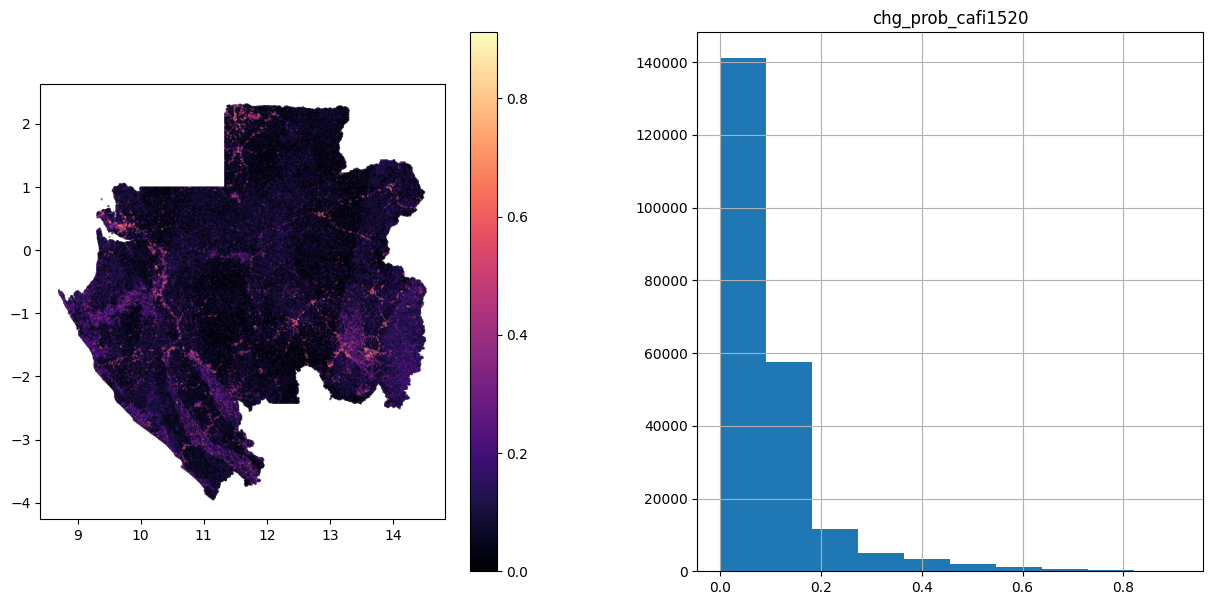

In [276]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('chg_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('chg_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'def_prob_cafi1520'}>], dtype=object)

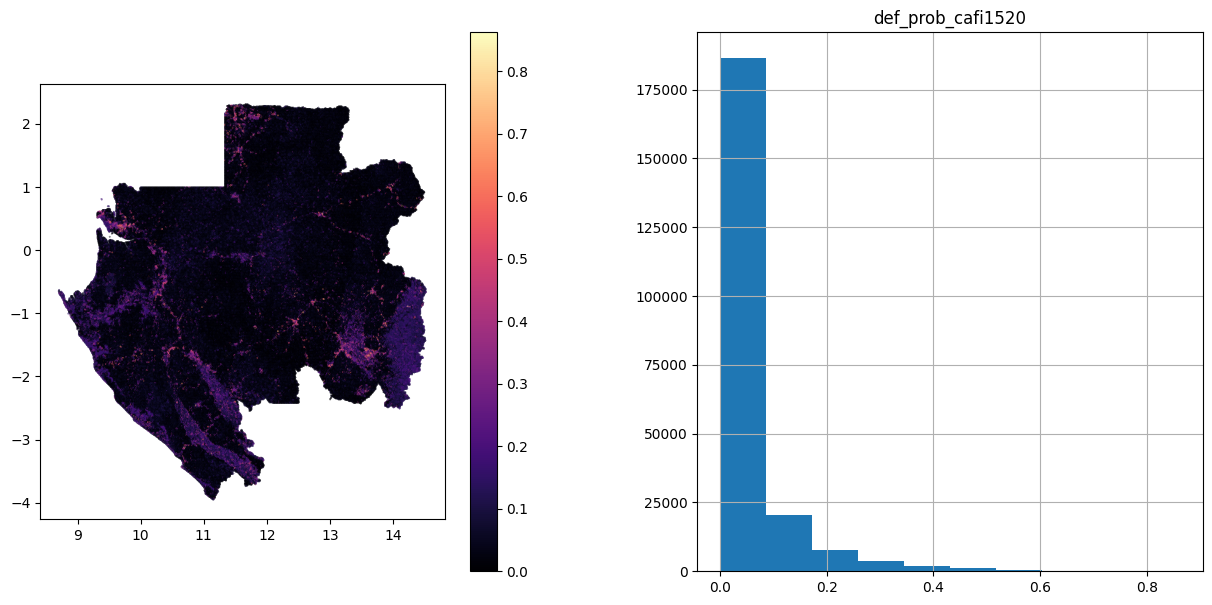

In [277]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('def_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('def_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'deg_prob_cafi1520'}>], dtype=object)

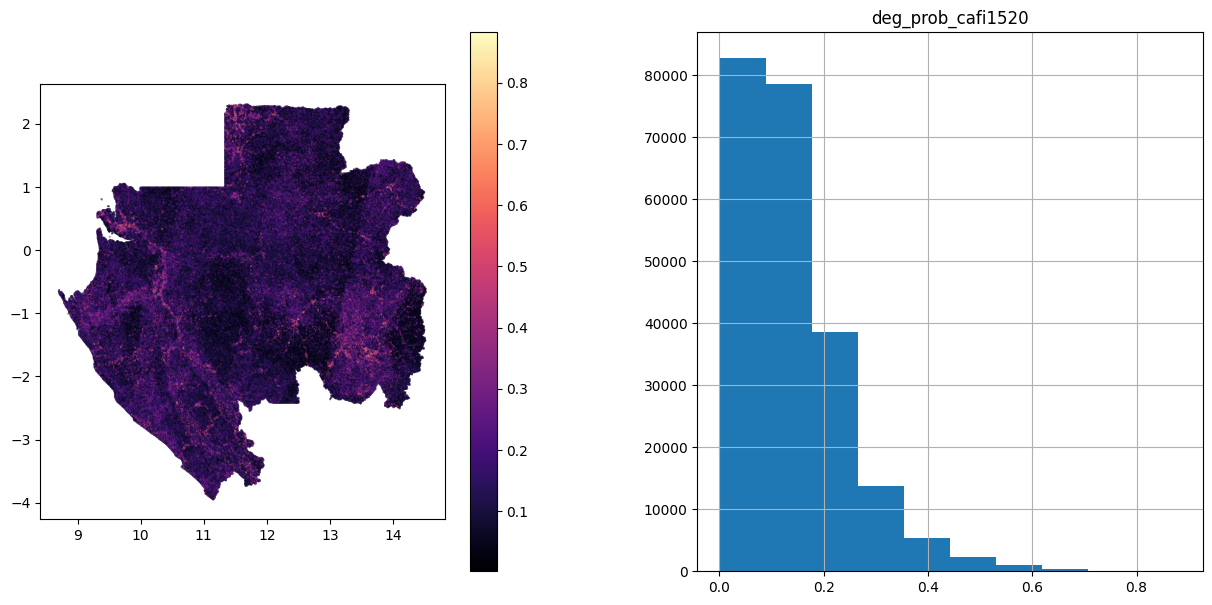

In [278]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('deg_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('deg_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'stable_prob_cafi1520'}>], dtype=object)

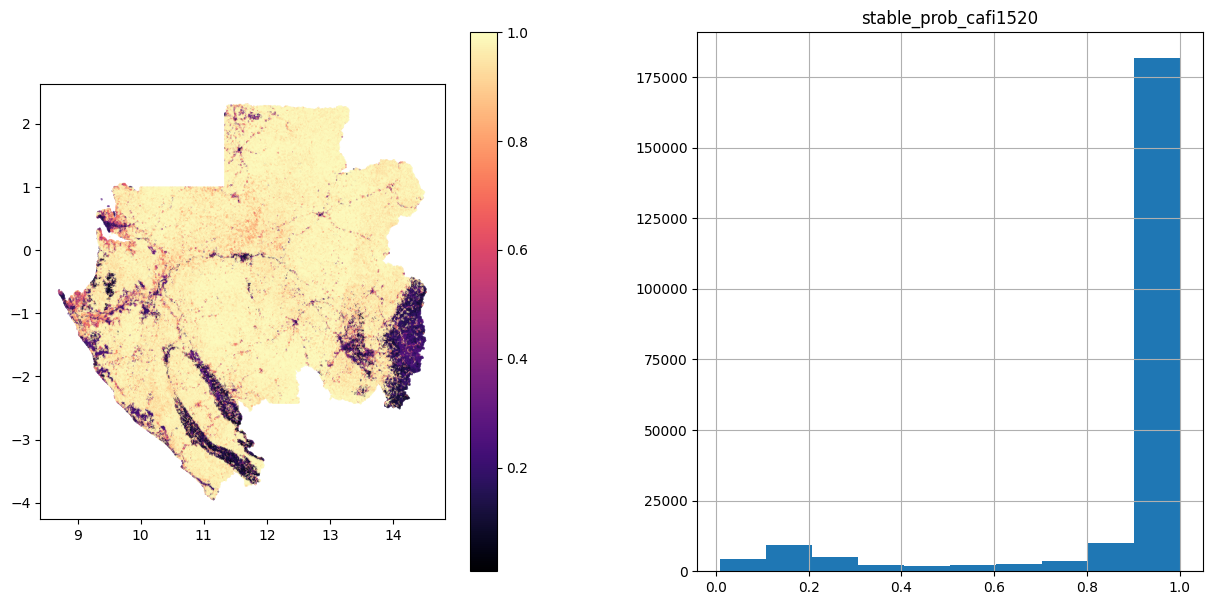

In [279]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('stable_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('stable_prob_cafi1520', ax=ax[1])

In [280]:
clf_db.columns

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date',
       ...
       'TropBiome', 'Change_Bin', 'Stable_Bin', 'Def_Bin', 'Deg_Bin', 'NF_Bin',
       'chg_prob_cafi1520', 'def_prob_cafi1520', 'deg_prob_cafi1520',
       'stable_prob_cafi1520'],
      dtype='object', length=151)

In [281]:
joined_df = clf_db

In [282]:
len(joined_df)

222878

### 3.2 Stratify with Kmeans

In [283]:
sample_size_no = 10000

In [284]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [285]:
joined_df['kmeans_chg'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,143313,0.041159,0.026968,3864.846602,1,4607,6430
1,68205,0.145184,0.045851,3127.237354,2,3728,3060
2,11360,0.442237,0.122825,1395.287569,3,1663,509


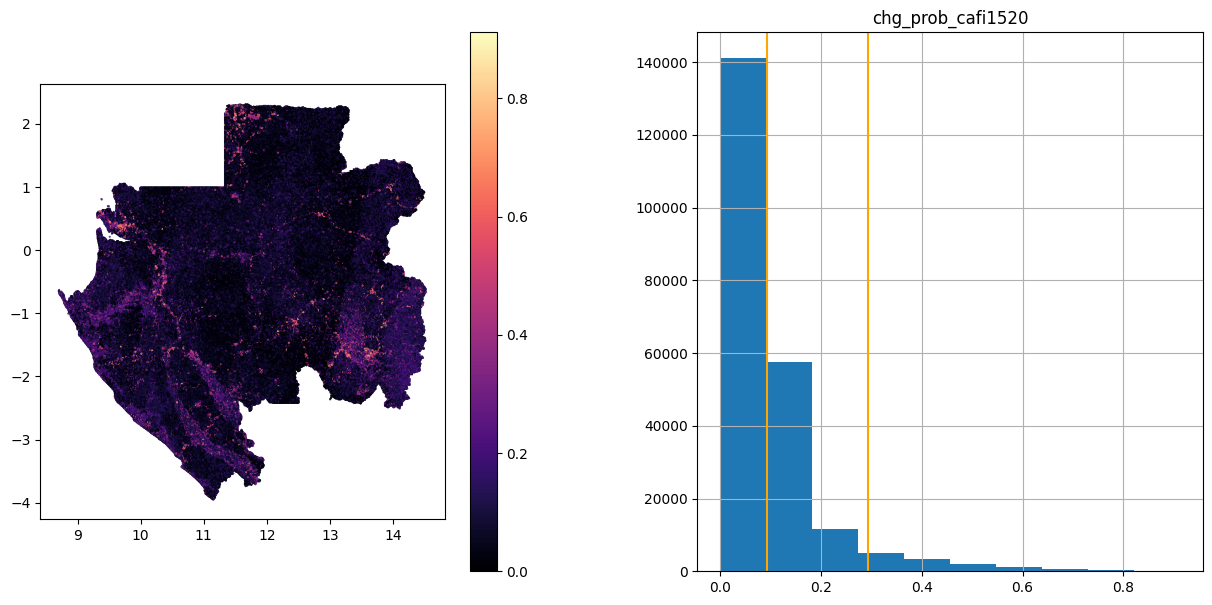

In [ ]:
h.plot_cluster(joined_df, prob_column='chg_prob_cafi1520', strata_column='kmeans_chg')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_chg', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_chg', ax=ax[1], bins=50)
samples

In [ ]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'def_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [ ]:
joined_df['kmeans_def'] = joined_df['stratum']

In [ ]:
h.plot_cluster(joined_df, prob_column='def_prob_cafi1520', strata_column='kmeans_def')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_def', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_def', ax=ax[1], bins=50)
samples

In [ ]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'deg_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [ ]:
joined_df['kmeans_deg'] = joined_df['stratum']

In [ ]:
h.plot_cluster(joined_df, prob_column='deg_prob_cafi1520', strata_column='kmeans_deg')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_deg', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_deg', ax=ax[1], bins=50)
samples

In [ ]:
cross_tab = pd.crosstab(index= joined_df['kmeans_def'], columns=joined_df['kmeans_deg'], margins=True, margins_name="Total")
cross_tab

In [ ]:
pd.pivot_table(joined_df,values='point_id',index=['kmeans_chg'],aggfunc="count", margins=True)

### 4. align column names, get coordinates


In [ ]:
joined_df['PLOTID'] = joined_df['point_id']

In [ ]:
joined_df.columns.tolist()

In [ ]:
#joined_df.drop(columns='stratum', inplace=True)

In [ ]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

### 5. export the points for your area with the change probability model

In [ ]:
joined_df.to_csv(all_points_out_file,index=False)

### now you may proceed to script 5c if you want to extract sample points for CEO